In [2]:
# from phasefield_scripts.load_files import *
# from phasefield_scripts.procedures import *
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
# import ipywidgets as widget
# from ipywidgets import fixed
import os
import pickle
import multiprocessing as mp
from tqdm import tqdm
from multiprocessing import Pool
# %matplotlib widget
import pandas as pd
import numpy as np 
import seaborn as sns

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

# from torchvision.datasets import ImageFolder

c:\Users\Nigar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Nigar\AppData\Local\Programs\Python\Python310\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# define the path to the data directory
data_dir = 'data_CNN_20,50_ready\\'

test_data_dir = 'test_data_CNN_ready\\'


# define the transformations to be applied to the images
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  #this will resize images to 224x224 but I am not sure if this is necessary
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# create the ImageFolder dataset
dataset = ImageFolder(data_dir, transform=transform) #subdirectories are the classes: T0 = 0 and T1 = 1
test_dataset = ImageFolder(test_data_dir, transform=transform)
# print(dataset.classes)


# split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create the data loaders for the train and validation sets
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size) #shuffle = False here, this is apparently better for validation data 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# print the number of samples in the train and validation sets
print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")


Number of samples in train set: 593
Number of samples in validation set: 149
Number of samples in test set: 672


In [57]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out


import torch.optim as optim

model  = LeNet5(num_classes=2)
learning_rate = 0.001

def get_accuracy(pred_arr, original_arr):
    pred_arr = pred_arr.detach().numpy()
    original_arr = original_arr.numpy()
    final_pred= []

    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0

    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)*100

    

#set up the loss function and the optimizer
cost = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

train_loss = []
train_acc = []
train_loss_per_epoch = []

#train!

#loss function from here: https://neptune.ai/blog/pytorch-loss-functions 
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    epoch_loss_sum = 0.0
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # forward feed
        outputs = model(inputs)
        train_acc.append(get_accuracy(outputs, labels))
        
        #calculate the loss
        loss = cost(outputs, labels) #same as cost(output_train, y_train)
        epoch_loss_sum += outputs.shape[0] * loss.item()
        train_loss.append(loss.item())
        
        # clear out the gradients from the lass step loss.backward() - understand this
        optimizer.zero_grad()
        
        #backward propagation - calculating gradients 
        loss.backward()
        
        #updating the weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')       
    
    train_loss_per_epoch.append(epoch_loss_sum / len(train_dataset))

         
    # epoch_loss = running_loss / len(train_loader)
    # train_loss.append(epoch_loss)


print('Finished Training')

PATH = './cifar_net_LeNet5_1.pth'
torch.save(model.state_dict(), PATH)

[1,     1] loss: 0.686
[1,     2] loss: 0.712
[1,     3] loss: 0.729
[1,     4] loss: 0.717
[1,     5] loss: 0.708
[1,     6] loss: 0.706
[1,     7] loss: 0.710
[1,     8] loss: 0.703
[1,     9] loss: 0.700
[1,    10] loss: 0.700
[1,    11] loss: 0.700
[1,    12] loss: 0.695
[1,    13] loss: 0.698
[1,    14] loss: 0.696
[1,    15] loss: 0.692
[1,    16] loss: 0.688
[1,    17] loss: 0.689
[1,    18] loss: 0.687
[1,    19] loss: 0.687
[1,    20] loss: 0.691
[1,    21] loss: 0.692
[1,    22] loss: 0.689
[1,    23] loss: 0.686
[1,    24] loss: 0.685
[1,    25] loss: 0.686
[1,    26] loss: 0.685
[1,    27] loss: 0.683
[1,    28] loss: 0.682
[1,    29] loss: 0.680
[1,    30] loss: 0.678
[1,    31] loss: 0.676
[1,    32] loss: 0.675
[1,    33] loss: 0.673
[1,    34] loss: 0.670
[1,    35] loss: 0.667
[1,    36] loss: 0.667
[1,    37] loss: 0.667
[1,    38] loss: 0.659
[2,     1] loss: 0.674
[2,     2] loss: 0.607
[2,     3] loss: 0.587
[2,     4] loss: 0.568
[2,     5] loss: 0.574
[2,     6] 

In [36]:
# net = LeNet5(2)
# net.load_state_dict(torch.load(PATH))

# dataiter = iter(val_loader)
# images, labels = next(dataiter)

# outputs = net(images)

# from sklearn.metrics import confusion_matrix

# correct = 0
# total = 0

# y_true = []
# y_pred = []


# loss = 0

# with torch.no_grad():
#     for data in val_loader:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
#         y_true += labels.tolist()
#         y_pred += predicted.tolist()
        
#         loss += cost(outputs, labels)
#     validation_loss = loss.item() / len(val_loader)

        
# confusion_mat = confusion_matrix(y_true, y_pred)

# print('Accuracy on validation set: %d %%' % (100 * correct / total))
# print(confusion_mat)

# plt.figure(figsize=(10, 6))

# # Create a heatmap of the confusion matrix
# sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')

# # Set the axis labels
# plt.xlabel('Predicted T1 transition')
# plt.ylabel('True T1 transition')

# Show the plot
# plt.show()



0.26627137660980227


In [60]:
net = LeNet5(2)
net.load_state_dict(torch.load(PATH))

dataiter = iter(val_loader)
images, labels = next(dataiter)

outputs = net(images)

from sklearn.metrics import confusion_matrix

correct = 0
total = 0

y_true = []
y_pred = []

validation_losses = []
val_loss_per_epoch = []

with torch.no_grad():
    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        epoch_loss_sum = 0.0
        val_loss_sum_epoch = 0.0
            
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            y_true += labels.tolist()
            y_pred += predicted.tolist()
            
            running_loss += cost(outputs, labels)
            val_loss_sum_epoch += outputs.shape[0] * loss.item()
            # print(running_loss)
            
        validation_loss = running_loss.item() / len(val_loader)
        validation_losses.append(validation_loss)
        val_loss_per_epoch.append(val_loss_sum_epoch / len(val_dataset))

        

# confusion_mat = confusion_matrix(y_true, y_pred)

# print('Accuracy on validation set: %d %%' % (100 * correct / total))
# print(confusion_mat)

# plt.figure(figsize=(10, 6))

# # Create a heatmap of the confusion matrix
# sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')

# # Set the axis labels
# plt.xlabel('Predicted T1 transition')
# plt.ylabel('True T1 transition')

# Show the plot
# plt.show()

    



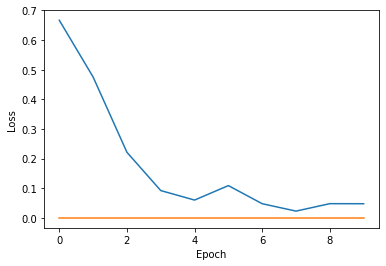

In [62]:
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Accuracy on a test set: 45 %


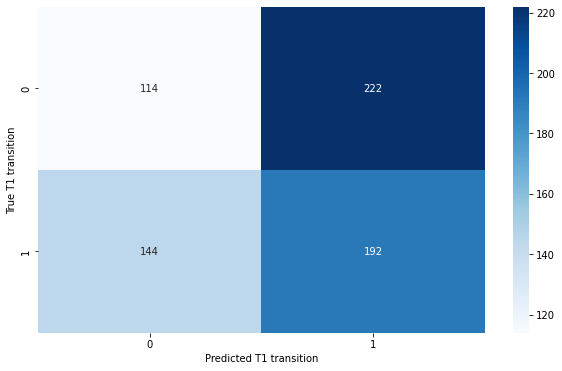

In [7]:
# Define an empty list to store loss values
model.eval()


dataiter = iter(test_loader)
images, labels = next(dataiter)

correct = 0
total = 0

y_true = []
y_pred = []


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        
confusion_mat = confusion_matrix(y_true, y_pred)

print('Accuracy on a test set: %d %%' % (100 * correct / total))
# print(confusion_mat)

plt.figure(figsize=(10, 6))

# # Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')

# # Set the axis labels
plt.xlabel('Predicted T1 transition')
plt.ylabel('True T1 transition')

# Show the plot
plt.show()


